In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from process.utils import load_history_graph

warnings.filterwarnings("ignore")

In [2]:
PATHS = {
    'data': os.path.join(os.getcwd(), 'data'),
    'train': os.path.join(os.getcwd(), 'data', 'train'),
    'test': os.path.join(os.getcwd(), 'data', 'test')
}

def load_datafile_path(file: str) -> str: return os.path.join(PATHS['data'], file)
def load_train_image_path(file: str) -> str: return os.path.join(PATHS['train'], file)
def load_test_image_path(file: str) -> str: return os.path.join(PATHS['test'], file)

In [3]:
train_info = pd.read_feather(load_datafile_path('train.ftr'))
train_info = train_info[train_info['year'] < 2012]
train_info = (
    train_info
    .sample(len(train_info))
    .reset_index(drop=True)
)


# Load images

In [4]:
train_info['example_path'][0].split('/')[-1]

'474.png'

In [5]:
images_paths = train_info['example_path']
images_names = [p.split('/')[-1] for p in images_paths]

In [6]:
images = [cv2.imread(load_train_image_path(images_names[i])) for i in tqdm(range(len(images_names)))]

100%|██████████| 1045/1045 [00:02<00:00, 457.84it/s]


Label = 2


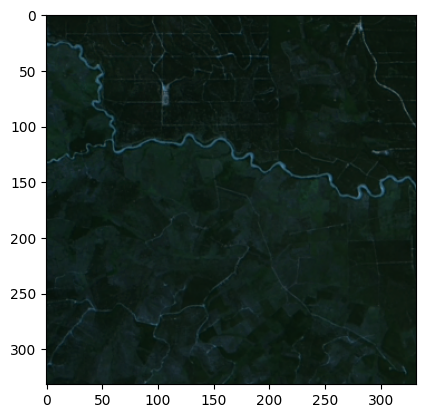

In [7]:
img_i = np.random.randint(0, len(images)+1)

print(f"Label = {train_info['label'][img_i]}")
plt.imshow(images[img_i])

In [8]:
class_num = train_info['label'].nunique()
img_height = images[0].shape[0]
img_width = images[0].shape[1]

# Model's data

In [9]:
total_count = len(images)
val_count = 100
labels = train_info['label'].apply(lambda x: 1 if x else 0).to_numpy()

In [10]:
train_images = np.array(images[:total_count-val_count])
val_images = np.array(images[total_count-val_count:])
assert len(train_images) + len(val_images) == total_count

In [11]:
train_labels = np.array(labels[:total_count-val_count])
val_labels = np.array(labels[total_count-val_count:])
assert len(train_labels) + len(val_labels) == total_count

# Model

In [12]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(class_num)
])

In [13]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10
)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
epochs = 50
batch_size = 32

history = model.fit(
  train_images,
  train_labels,
  validation_data=(val_images, val_labels),
  epochs=epochs,
  batch_size=batch_size,
  callbacks=[early_stopping_callback]
)

Epoch 1/50
30/30 [==============================] - 13s 419ms/step - loss: 0.7302 - accuracy: 0.5524 - val_loss: 0.6795 - val_accuracy: 0.5500
Epoch 2/50
30/30 [==============================] - 13s 421ms/step - loss: 0.6509 - accuracy: 0.5884 - val_loss: 0.6616 - val_accuracy: 0.5400
Epoch 3/50
30/30 [==============================] - 13s 421ms/step - loss: 0.6241 - accuracy: 0.6307 - val_loss: 0.6560 - val_accuracy: 0.5600
Epoch 4/50
30/30 [==============================] - 13s 423ms/step - loss: 0.5794 - accuracy: 0.6963 - val_loss: 0.5944 - val_accuracy: 0.6700
Epoch 5/50
30/30 [==============================] - 13s 421ms/step - loss: 0.4854 - accuracy: 0.7735 - val_loss: 0.6089 - val_accuracy: 0.6500
Epoch 6/50
30/30 [==============================] - 13s 428ms/step - loss: 0.4275 - accuracy: 0.8000 - val_loss: 0.6503 - val_accuracy: 0.6400
Epoch 7/50
30/30 [==============================] - 13s 428ms/step - loss: 0.3658 - accuracy: 0.8455 - val_loss: 0.6350 - val_accuracy: 0.7000

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
assert len(acc) == len(val_acc) == len(loss) == len(val_loss)

fig = load_history_graph(acc, val_acc, loss, val_loss)
fig.show()